tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.5618e-07, 1.5767e-07, 1.5993e-07,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.9910e-04, 6.0618e-04, 6.1674e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


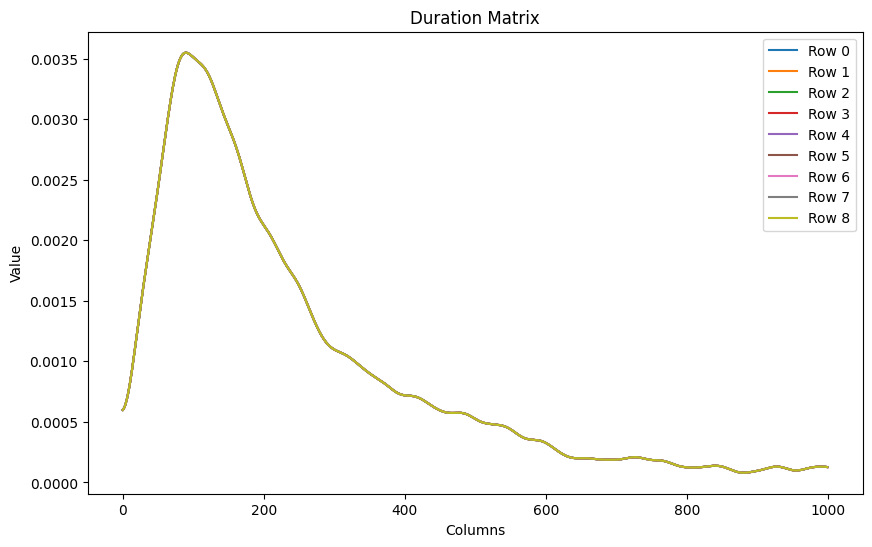

In [121]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import params

# 0=S, 1=Es, 2=Ef, 3=Em, 4=El, 5=I, 6=5', 7=3', 8=epsilon
states = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
Transition = torch.tensor([[0.0, params.p1E, 1-params.p1E, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 1-params.pEO, params.pEO, 0.0, 0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

Duration = torch.zeros(9, 5000000)
Duration[0, 0] = 1
Duration[1] = torch.tensor(params.lengthSingleExons)
Duration[2] = torch.tensor(params.lengthFirstExons)
Duration[3] = torch.tensor(params.lengthMiddleExons)
Duration[4] = torch.tensor(params.lengthLastExons)
Duration[5] = torch.tensor(params.lengthIntrons)
Duration[6, 0] = 1
Duration[7, 0] = 1
Duration[-1, 0] = 1
print(Duration)

# Plotting the matrix
plt.figure(figsize=(10, 6))
for i in range(Duration.shape[0]):
    plt.plot(Duration[2, :1000].numpy(), label=f"Row {i}")

plt.xlabel("Columns")
plt.ylabel("Value")
plt.title("Duration Matrix")
plt.legend(loc="upper right")
plt.show()



In [122]:
np.where(Duration.any(0))

(array([     0,      1,      2, ..., 773207, 773208, 773209]),)

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
torch.Size([9, 1202])


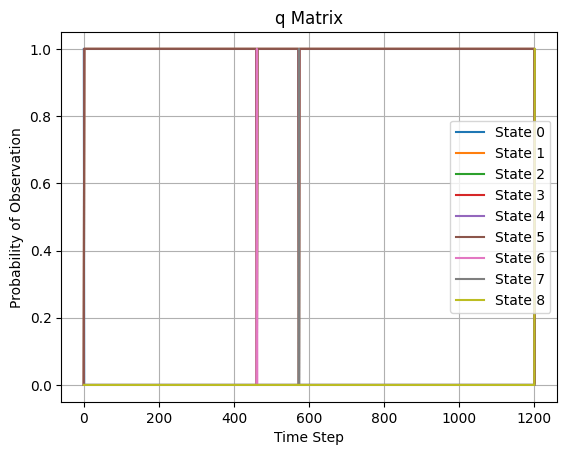

In [128]:
q3 = torch.tensor([[1], [0], [0]]).repeat(1, 1200) # [[null],[5'],[3']]
q3[:, 460] = torch.tensor([0, 1, 0]) # 5' site
q3[:, 572] = torch.tensor([0, 0, 1]) # 3' site
#q3[:, 590] = torch.tensor([0.4, 0.6, 0]) # 5' site
print(q3)
q = torch.zeros(9, q3.shape[1])
q[1:6] = q3[0, :]
q[6] = q3[1, :]
q[7] = q3[2, :]
start = torch.zeros(9, 1)
start[0] = 1.0
end = torch.zeros(9, 1)
end[-1] = 1.0
q = torch.cat((start, q, end), dim=1)

print(q.shape)
# plot
time_steps = range(len(q[0]))
plt.figure()
for state in states:
    probs = [q[state][i].detach().numpy() for i in range(len(q[1]))]
    plt.plot(time_steps, probs, label=f"State {state}")

plt.xlabel('Time Step')
plt.ylabel('Probability of Observation')
plt.title('q Matrix')
plt.legend()
plt.grid(True)
plt.show()

In [129]:
def matrix_mult_factor(log_alpha_row, Transition):
    alpha_row = torch.exp(log_alpha_row)
    alpha_row = alpha_row.to(torch.float64)
    product = alpha_row @ Transition
    factor = torch.sum(product)
    return torch.log(factor)

def matrix_mult_vec(log_alpha_row, Transition):
    log_alpha_row = log_alpha_row.to(torch.float64)
    result = torch.exp(log_alpha_row)@Transition
    if torch.sum(result) != 0:
        return torch.log(result / torch.sum(result))
    else:
        return torch.zeros_like(result)

tensor([[0.0000, 0.0742, 0.9258, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.9026, 0.0974, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)
1000 1202


  0%|          | 0/1000 [00:00<?, ?it/s]

factor tensor([[9.0017e-13, 9.0017e-13, 9.0017e-13, 9.0017e-13, 9.0017e-13, 9.0017e-13,
         9.0017e-13, 9.0017e-13, 9.0017e-13]], dtype=torch.float64)
vector tensor([-29.9336,  -2.6014,  -0.0771, -29.9336, -29.9336, -29.9336, -29.9336,
        -29.9336, -29.9336], dtype=torch.float64)
Duration tensor([0.0000e+00, 1.4620e-05, 3.5172e-03, 7.0511e-03, 9.7785e-04, 1.1426e-03,
        0.0000e+00, 0.0000e+00, 0.0000e+00])
q tensor([0., 1., 1., 1., 1., 1., 0., 0., 0.])


  0%|          | 0/202 [00:00<?, ?it/s]

torch.Size([1202, 9])
q.grad None
[1.00000000e+00 1.56175579e-33 5.99101178e-30 1.64213063e-30
 4.45435033e-30 9.99999230e-40 9.99998215e-27 9.99998215e-27
 9.99998215e-27] [1.99999732e-26 1.15838290e-08 5.54664355e-04 1.64213199e-17
 4.45434341e-17 9.99999107e-27 9.99999107e-27 9.99999107e-27
 9.99999107e-27]


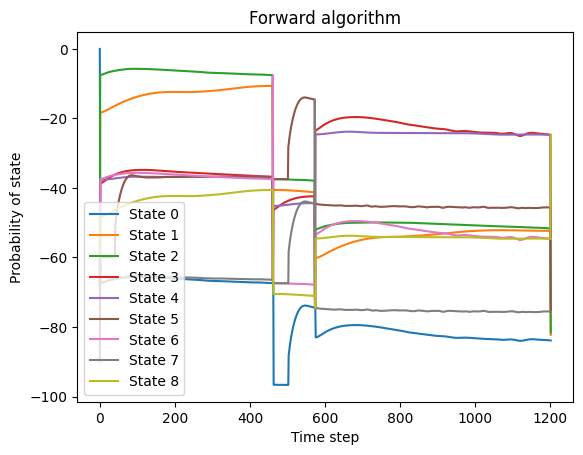

In [130]:
def forward(states, Transition, q, Duration):
    T = len(q[0])
    N = len(states)
    D = len(Duration[:, 0:1000][0])
    log_alpha_list = []
    start = torch.zeros(N)
    start[0] = 1
    epsilon = 1e-13
    print(Transition)
    print(D, T)

    import tqdm.auto as tqdm

    # initialization
    for t in tqdm.trange(min(D, T)):
        new_log_alpha = torch.log(start+epsilon) + torch.log(Duration[:, t]+epsilon) + torch.sum(torch.log(q[:, :t+1]+epsilon), dim=1)
        for d in range(t):
            factor = torch.column_stack([matrix_mult_factor(log_alpha_list[t-d-1], Transition+epsilon)]*N)
            vector = matrix_mult_vec(log_alpha_list[t-d-1], Transition+epsilon)
            if t == 100 and d == t - 1:
                print('factor', factor)
                print('vector', vector)
                print('Duration', Duration[:, d])
                print('q', q[:, t-d:t+1].prod(dim=1))
            new_log_alpha = torch.logaddexp(new_log_alpha, factor + vector + torch.log(Duration[:, d]+epsilon) + torch.sum(torch.log(q[:, t-d:t+1]+epsilon), dim=1)).squeeze()
        log_alpha_list.append(new_log_alpha)
    
    # fill log_alpha[D:]
    for t in tqdm.trange(D, T):
        log_alpha_list.append(torch.full((N,), -float('inf')))
        new_log_alpha = log_alpha_list[t]
        for d in range(D):
            factor = torch.column_stack([matrix_mult_factor(log_alpha_list[t-d-1], Transition+epsilon)]*N)
            vector = matrix_mult_vec(log_alpha_list[t-d-1], Transition+epsilon)
            new_log_alpha = torch.logaddexp(new_log_alpha, factor + vector + torch.log(Duration[:, d]+epsilon) + torch.sum(torch.log(q[:, t-d:t+1]+epsilon), dim=1)).squeeze()
        log_alpha_list[t] = new_log_alpha 

    log_alpha = torch.exp(torch.stack(log_alpha_list))
    print(log_alpha.shape)
    log_alpha_sum = torch.sum(log_alpha)
    return log_alpha


fwd = forward(states, Transition, q, Duration).detach().numpy()
print('q.grad', q.grad)
print(fwd[0], fwd[1])

# plot
for state in states:
    probs = [fwd[t][state] for t in range(len(q[0]))]
    plt.plot(time_steps, np.log(probs), label =f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Forward algorithm')
plt.legend()
plt.show()

  0%|          | 0/1201 [00:00<?, ?it/s]

log_beta[t+d+1] tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
Transition tensor([[0.0000, 0.0742, 0.9258, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.9026, 0.0974, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)
Duration tensor([0.0000e+00, 1.4156e-05, 3.5223e-03, 7.0276e-03, 9.8071e-04, 1.1657e-03,
        0.0000e+00, 0.0000e+00, 0.0000e+00])
q tensor([[0., 0., 0., 0., 

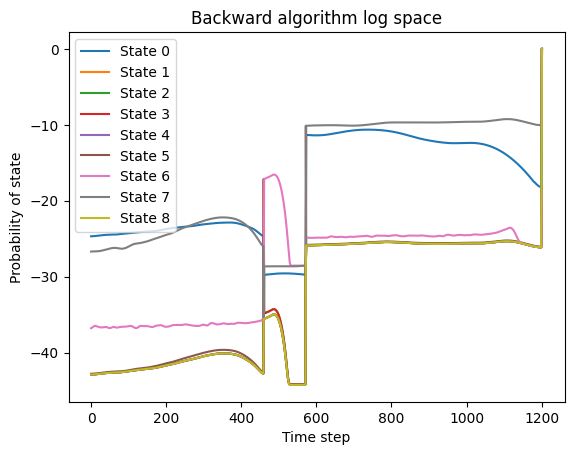

In [131]:
def backward(states, Transition, q, Duration):
    T = len(q[0])
    N = len(states)
    D = len(Duration[:,0:1000][0])
    epsilon = 1e-8
    log_beta = torch.full((T, N), -float('inf'))

    # initialization, log_beta[-1]
    log_beta_new = log_beta.clone()
    log_beta_new[-1] = torch.zeros(N)
    log_beta = log_beta_new

    import tqdm.auto as tqdm
    
    # fill log_beta[:-1]
    for t in tqdm.trange(T - 2, -1, -1):
        for d in range(D):
            if t + d <= T - 2:
                log_beta_new = log_beta.clone()
                if t == T - 100 and d == 98:
                    print('log_beta[t+d+1]', log_beta[t+d+1])
                    print('Transition', Transition)
                    print('Duration', Duration[:, d])
                    print('q', q[:, t+1:t+d+2])
                log_beta_new[t] = torch.logaddexp(log_beta[t], 
                                                  torch.logsumexp(
                                                      torch.row_stack([log_beta[t+d+1]]*N)
                                                      + torch.log(Transition + epsilon)
                                                      + torch.log(torch.row_stack([Duration[:, d]]*N) + epsilon) 
                                                      + torch.sum(torch.log(q[:, t + 1:t + d + 2] + epsilon), axis=1), 
                                                                  axis=1))
                log_beta = log_beta_new
#        if t < T - 150:
 #           break
                
    log_beta = torch.exp(log_beta)
    log_beta_sum = torch.sum(log_beta)
    # log_beta_sum.backward()

    return log_beta


bwd = backward(states, Transition, q, Duration).detach().numpy()
print('q.grad', q.grad)
print(bwd[-1], bwd[-2])

# plot
for state in states:
    probs = [bwd[t][state] for t in range(len(q[0]))]
    plt.plot(range(len(q[0])), np.log(probs), label=f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Backward algorithm log space')
plt.legend()
plt.show()

tensor([[0.0000, 0.0742, 0.9258, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.9026, 0.0974, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)
1000 1202


  0%|          | 0/1000 [00:00<?, ?it/s]

factor tensor([[9.0017e-13, 9.0017e-13, 9.0017e-13, 9.0017e-13, 9.0017e-13, 9.0017e-13,
         9.0017e-13, 9.0017e-13, 9.0017e-13]], dtype=torch.float64)
vector tensor([-29.9336,  -2.6014,  -0.0771, -29.9336, -29.9336, -29.9336, -29.9336,
        -29.9336, -29.9336], dtype=torch.float64)
Duration tensor([0.0000e+00, 1.4620e-05, 3.5172e-03, 7.0511e-03, 9.7785e-04, 1.1426e-03,
        0.0000e+00, 0.0000e+00, 0.0000e+00])
q tensor([0., 1., 1., 1., 1., 1., 0., 0., 0.])


  0%|          | 0/202 [00:00<?, ?it/s]

torch.Size([1202, 9])


  0%|          | 0/1201 [00:00<?, ?it/s]

log_beta[t+d+1] tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
Transition tensor([[0.0000, 0.0742, 0.9258, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.9026, 0.0974, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)
Duration tensor([0.0000e+00, 1.4156e-05, 3.5223e-03, 7.0276e-03, 9.8071e-04, 1.1657e-03,
        0.0000e+00, 0.0000e+00, 0.0000e+00])
q tensor([[0., 0., 0., 0., 

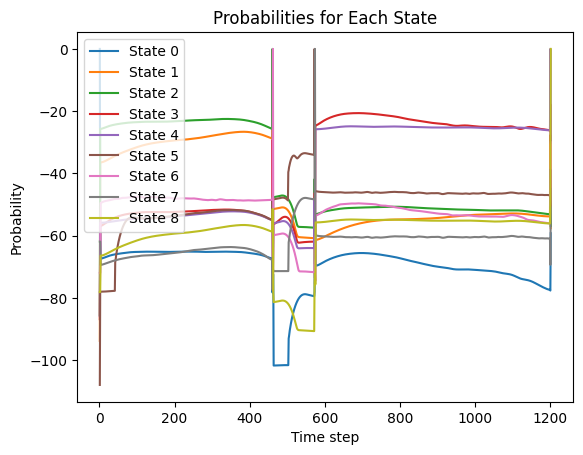

In [132]:
def fb_alg(states, Transition, q, Duration):
    T = len(q[0])
    alpha = forward(states, Transition, q, Duration)
    beta = backward(states, Transition, q, Duration)
    fb_probs = alpha * beta

    # normalize
    fb_sum = torch.sum(alpha[T-1])
    if fb_sum:
        fb_probs = fb_probs / fb_sum
    
    #(fb_probs[2][2]).backward()
    return fb_probs

fb_probs = fb_alg(states, Transition, q, Duration).detach().numpy()
#print('q.grad:', (q.grad * 100).round().int())
print(fb_probs)

# plot
for state in states:
    probs = [fb_probs[t][state] for t in range(len(fb_probs))]
    plt.plot(range(1, len(fb_probs) + 1), np.log(probs), label=f'State {state}')

plt.xlabel('Time step')
plt.ylabel('Probability')
plt.title('Probabilities for Each State')
plt.legend()
plt.show()